In [1]:
#%%
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
class GAN(object):
    
    def __init__(self, height= 10, channels = 1):

        self.SHAPE = (height,channels)
        self.HEIGHT = height
        self.CHANNELS = channels

        self.OPTIMIZER = Adam(lr=0.0002, beta_1 = 0.5,decay=8e-9)

        self.G = self._generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)

        self.D = self._discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'])

        self.stacked_G_D = self._stacked_G_D()

        self.stacked_G_D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)

        self.G_loss = []
        self.D_C_loss = []
        self.D_S_loss = []
        self.EPOCHS = 2000
    def _generator(self):

        model = Sequential()
        #input layer
        model.add(Dense(20, input_shape = (self.HEIGHT,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #layer 2
        model.add(Dense(40))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(40))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #layer 3
        model.add(Dense(80))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(10, activation='tanh'))

        model.add(Reshape(self.SHAPE))
        
        return model

    def _discriminator(self):

        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def _stacked_G_D(self):
        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model
        
    def train(self, data, epochs = 2000,batch = 6, sparse_clean_ratio = 0.3):
        self.EPOCHS = epochs
        for epoch in range(epochs):
            
            # train discriminator
            random_index = np.random.randint(0, len(data) - batch//2)
            clean_mixes = data[random_index : random_index + batch//2]

            # create sparse mixes
            sparse_mix = clean_mixes
            for mix in sparse_mix:
                rand_indexs = np.random.randint(0,len(mix),round(len(mix)*sparse_clean_ratio))
                for i in rand_indexs:
                    mix[i]=0
            
            synthetic_mixes = self.G.predict_on_batch(sparse_mix)

            # combined_batch = np.concatenate((clean_mixes.reshape(synthetic_mixes.shape),synthetic_mixes))
            # mask_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            # d_loss = self.D.train_on_batch(combined_batch, mask_batch)
            d_loss_clean = self.D.train_on_batch(clean_mixes.reshape(synthetic_mixes.shape),np.ones((np.int64(batch/2), 1)))
            d_loss_synthetic = self.D.train_on_batch(synthetic_mixes,np.zeros((np.int64(batch/2), 1)))

            
            # train generator
            random_index = np.random.randint(0, len(data), size = (1,batch))
            sparse_mix = data[random_index]
            for mix in sparse_mix:
                rand_indexs = np.random.randint(0,high=len(mix),size=round(len(mix)*sparse_clean_ratio))
                mix[rand_indexs] = 0
            y_label = np.ones((batch,1))

            g_loss = self.stacked_G_D.train_on_batch(np.squeeze(sparse_mix),y_label)

            self.G_loss.append(g_loss)
            self.D_C_loss.append(d_loss_clean[0])
            self.D_S_loss.append(d_loss_synthetic[0])
            print ('epoch: %d, [Discriminator :: loss: %f,%f], [ Generator :: loss: %f]' % (epoch, d_loss_clean[0],d_loss_synthetic[0], g_loss))
    def plot(self):
        import matplotlib.pyplot as plt
        plt.style.use('seaborn-whitegrid')
        
        fig = plt.figure()
        ax = plt.axes()

        x = range(self.EPOCHS)
        ax.plot(x,self.G_loss, color = 'orange', label = "Generator")
        ax.plot(x,self.D_C_loss, 'b-', alpha = 0.5, label = "Discriminator - Clean")
        ax.plot(x,self.D_S_loss, 'g-', alpha = 0.5, label = "Discriminator - Synthetic")
        ax.legend(loc = 'center left',bbox_to_anchor=(1,0.5))
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        plt.show()

In [5]:

if __name__ == '__main__':

    # set random seed
    random.seed(1)
    
    
    # Load data from CSV file
    data = pd.read_csv("~/Desktop/Concrete-NN/data/ets.csv", dtype=float)
    # Removing cost for now as it is not important
    data = data.drop('Cost ($/m3)',1)
    # Creating Scaler
    scaler = MinMaxScaler(feature_range = (-1,1))
    # scaling datas
    scaled_data = scaler.fit_transform(data)
    np.random.shuffle(scaled_data)

    gan = GAN()
    gan.train(scaled_data, epochs=5000,batch = 6,sparse_clean_ratio=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 55        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 5)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: loss: 0.584855,0.703566], [ Generator :: loss: 0.654224]
epoch: 1, [Discriminator :: loss: 0.653776,0.853934], [ Generator :: loss: 0.621251]
epoch: 2, [Discriminator :: loss: 0.682475,0.776672], [ Generator :: loss: 0.638208]
epoch: 3, [Discriminator :: loss: 0.663837,0.744459], [ Generator :: loss: 0.588378]
epoch: 4, [Discriminator :: loss: 0.692856,0.901907], [ Generator :: loss: 0.609791]
epoch: 5, [Discriminator :: loss: 0.628147,0.727629], [ Generator :: loss: 0.603303]
epoch: 6, [Discriminator :: loss: 0.591335,0.703418], [ Generator :: loss: 0.606417]
epoch: 7, [Discriminator :: loss: 0.604145,0.790555], [ Generator :: loss: 0.603036]
epoch: 8, [Discriminator :: loss: 0.705673,0.742228], [ Generator :: loss: 0.588893]
epoch: 9, [Discriminator :: loss: 0.658861,0.741063], [ Generator :: loss: 0.593635]
epoch: 10, [Discriminator :: loss: 0.717024,0.720406], [ Generator :: loss: 0.674243]
epoch: 11, [Discriminator :: loss: 0.658529,0.759665], [ Generat

epoch: 120, [Discriminator :: loss: 0.701187,0.760805], [ Generator :: loss: 0.509594]
epoch: 121, [Discriminator :: loss: 0.689691,0.922250], [ Generator :: loss: 0.508948]
epoch: 122, [Discriminator :: loss: 0.706481,0.800681], [ Generator :: loss: 0.525917]
epoch: 123, [Discriminator :: loss: 0.666387,0.766357], [ Generator :: loss: 0.533107]
epoch: 124, [Discriminator :: loss: 0.695527,0.715501], [ Generator :: loss: 0.496578]
epoch: 125, [Discriminator :: loss: 0.689799,0.882584], [ Generator :: loss: 0.525382]
epoch: 126, [Discriminator :: loss: 0.664105,0.945263], [ Generator :: loss: 0.529515]
epoch: 127, [Discriminator :: loss: 0.680590,0.816384], [ Generator :: loss: 0.498350]
epoch: 128, [Discriminator :: loss: 0.640151,0.881506], [ Generator :: loss: 0.491731]
epoch: 129, [Discriminator :: loss: 0.671102,0.976478], [ Generator :: loss: 0.463082]
epoch: 130, [Discriminator :: loss: 0.670937,0.831453], [ Generator :: loss: 0.519000]
epoch: 131, [Discriminator :: loss: 0.71725

epoch: 228, [Discriminator :: loss: 0.729061,0.831444], [ Generator :: loss: 0.562281]
epoch: 229, [Discriminator :: loss: 0.726837,0.814614], [ Generator :: loss: 0.570246]
epoch: 230, [Discriminator :: loss: 0.713246,0.754772], [ Generator :: loss: 0.574498]
epoch: 231, [Discriminator :: loss: 0.712610,0.794239], [ Generator :: loss: 0.531224]
epoch: 232, [Discriminator :: loss: 0.695752,0.945215], [ Generator :: loss: 0.557984]
epoch: 233, [Discriminator :: loss: 0.704723,0.844634], [ Generator :: loss: 0.520054]
epoch: 234, [Discriminator :: loss: 0.713123,0.989366], [ Generator :: loss: 0.551529]
epoch: 235, [Discriminator :: loss: 0.711222,0.901734], [ Generator :: loss: 0.544208]
epoch: 236, [Discriminator :: loss: 0.709737,0.831593], [ Generator :: loss: 0.548149]
epoch: 237, [Discriminator :: loss: 0.693222,0.805064], [ Generator :: loss: 0.501814]
epoch: 238, [Discriminator :: loss: 0.705066,0.819469], [ Generator :: loss: 0.520382]
epoch: 239, [Discriminator :: loss: 0.70446

epoch: 331, [Discriminator :: loss: 0.716683,0.753366], [ Generator :: loss: 0.569500]
epoch: 332, [Discriminator :: loss: 0.716436,0.803838], [ Generator :: loss: 0.593164]
epoch: 333, [Discriminator :: loss: 0.715442,0.822226], [ Generator :: loss: 0.559854]
epoch: 334, [Discriminator :: loss: 0.729704,0.802461], [ Generator :: loss: 0.639556]
epoch: 335, [Discriminator :: loss: 0.731720,0.847113], [ Generator :: loss: 0.597360]
epoch: 336, [Discriminator :: loss: 0.716100,0.791341], [ Generator :: loss: 0.589301]
epoch: 337, [Discriminator :: loss: 0.707802,0.767551], [ Generator :: loss: 0.630629]
epoch: 338, [Discriminator :: loss: 0.719686,0.810146], [ Generator :: loss: 0.607440]
epoch: 339, [Discriminator :: loss: 0.714756,0.820975], [ Generator :: loss: 0.594662]
epoch: 340, [Discriminator :: loss: 0.714751,0.662884], [ Generator :: loss: 0.627035]
epoch: 341, [Discriminator :: loss: 0.728301,0.716763], [ Generator :: loss: 0.590895]
epoch: 342, [Discriminator :: loss: 0.71930

epoch: 431, [Discriminator :: loss: 0.721031,0.759518], [ Generator :: loss: 0.645676]
epoch: 432, [Discriminator :: loss: 0.723286,0.756238], [ Generator :: loss: 0.643025]
epoch: 433, [Discriminator :: loss: 0.724812,0.751708], [ Generator :: loss: 0.645182]
epoch: 434, [Discriminator :: loss: 0.724195,0.716546], [ Generator :: loss: 0.667197]
epoch: 435, [Discriminator :: loss: 0.721596,0.708239], [ Generator :: loss: 0.664972]
epoch: 436, [Discriminator :: loss: 0.721244,0.755401], [ Generator :: loss: 0.671217]
epoch: 437, [Discriminator :: loss: 0.723072,0.752057], [ Generator :: loss: 0.691660]
epoch: 438, [Discriminator :: loss: 0.725991,0.723249], [ Generator :: loss: 0.643871]
epoch: 439, [Discriminator :: loss: 0.724619,0.718912], [ Generator :: loss: 0.678754]
epoch: 440, [Discriminator :: loss: 0.727559,0.697497], [ Generator :: loss: 0.680103]
epoch: 441, [Discriminator :: loss: 0.724011,0.705420], [ Generator :: loss: 0.654126]
epoch: 442, [Discriminator :: loss: 0.73689

epoch: 532, [Discriminator :: loss: 0.725150,0.686740], [ Generator :: loss: 0.698435]
epoch: 533, [Discriminator :: loss: 0.724165,0.701262], [ Generator :: loss: 0.726336]
epoch: 534, [Discriminator :: loss: 0.720174,0.684098], [ Generator :: loss: 0.687460]
epoch: 535, [Discriminator :: loss: 0.724230,0.699075], [ Generator :: loss: 0.701148]
epoch: 536, [Discriminator :: loss: 0.726546,0.664887], [ Generator :: loss: 0.698146]
epoch: 537, [Discriminator :: loss: 0.724279,0.693348], [ Generator :: loss: 0.732140]
epoch: 538, [Discriminator :: loss: 0.726676,0.682101], [ Generator :: loss: 0.716216]
epoch: 539, [Discriminator :: loss: 0.728123,0.688982], [ Generator :: loss: 0.721563]
epoch: 540, [Discriminator :: loss: 0.722382,0.681466], [ Generator :: loss: 0.704942]
epoch: 541, [Discriminator :: loss: 0.724340,0.674953], [ Generator :: loss: 0.693942]
epoch: 542, [Discriminator :: loss: 0.724340,0.670795], [ Generator :: loss: 0.704107]
epoch: 543, [Discriminator :: loss: 0.72956

epoch: 629, [Discriminator :: loss: 0.726284,0.651497], [ Generator :: loss: 0.737379]
epoch: 630, [Discriminator :: loss: 0.729716,0.668510], [ Generator :: loss: 0.720109]
epoch: 631, [Discriminator :: loss: 0.724054,0.661002], [ Generator :: loss: 0.738695]
epoch: 632, [Discriminator :: loss: 0.724037,0.661872], [ Generator :: loss: 0.733897]
epoch: 633, [Discriminator :: loss: 0.725543,0.650883], [ Generator :: loss: 0.726337]
epoch: 634, [Discriminator :: loss: 0.723982,0.656073], [ Generator :: loss: 0.730735]
epoch: 635, [Discriminator :: loss: 0.723953,0.659081], [ Generator :: loss: 0.731152]
epoch: 636, [Discriminator :: loss: 0.723950,0.652779], [ Generator :: loss: 0.714771]
epoch: 637, [Discriminator :: loss: 0.725810,0.655177], [ Generator :: loss: 0.738330]
epoch: 638, [Discriminator :: loss: 0.723967,0.656266], [ Generator :: loss: 0.736731]
epoch: 639, [Discriminator :: loss: 0.723949,0.655479], [ Generator :: loss: 0.730815]
epoch: 640, [Discriminator :: loss: 0.72930

epoch: 728, [Discriminator :: loss: 0.722571,0.637809], [ Generator :: loss: 0.741959]
epoch: 729, [Discriminator :: loss: 0.722550,0.641051], [ Generator :: loss: 0.741735]
epoch: 730, [Discriminator :: loss: 0.722531,0.642710], [ Generator :: loss: 0.741640]
epoch: 731, [Discriminator :: loss: 0.722514,0.631950], [ Generator :: loss: 0.732211]
epoch: 732, [Discriminator :: loss: 0.723746,0.621966], [ Generator :: loss: 0.740799]
epoch: 733, [Discriminator :: loss: 0.722485,0.635319], [ Generator :: loss: 0.737964]
epoch: 734, [Discriminator :: loss: 0.722471,0.631532], [ Generator :: loss: 0.741489]
epoch: 735, [Discriminator :: loss: 0.722459,0.632388], [ Generator :: loss: 0.732354]
epoch: 736, [Discriminator :: loss: 0.722443,0.631578], [ Generator :: loss: 0.694555]
epoch: 737, [Discriminator :: loss: 0.722423,0.630602], [ Generator :: loss: 0.732300]
epoch: 738, [Discriminator :: loss: 0.722402,0.628248], [ Generator :: loss: 0.732235]
epoch: 739, [Discriminator :: loss: 0.72793

epoch: 836, [Discriminator :: loss: 0.720142,0.601040], [ Generator :: loss: 0.770013]
epoch: 837, [Discriminator :: loss: 0.720116,0.604027], [ Generator :: loss: 0.785397]
epoch: 838, [Discriminator :: loss: 0.720095,0.598614], [ Generator :: loss: 0.709760]
epoch: 839, [Discriminator :: loss: 0.720074,0.642299], [ Generator :: loss: 0.733916]
epoch: 840, [Discriminator :: loss: 0.732137,0.648211], [ Generator :: loss: 0.734033]
epoch: 841, [Discriminator :: loss: 0.720015,0.624547], [ Generator :: loss: 0.734111]
epoch: 842, [Discriminator :: loss: 0.719990,0.617186], [ Generator :: loss: 0.734165]
epoch: 843, [Discriminator :: loss: 0.724462,0.630085], [ Generator :: loss: 0.734200]
epoch: 844, [Discriminator :: loss: 0.719955,0.606336], [ Generator :: loss: 0.765544]
epoch: 845, [Discriminator :: loss: 0.721700,0.593596], [ Generator :: loss: 0.764153]
epoch: 846, [Discriminator :: loss: 0.732077,0.621414], [ Generator :: loss: 0.768594]
epoch: 847, [Discriminator :: loss: 0.71990

epoch: 941, [Discriminator :: loss: 0.717503,0.596336], [ Generator :: loss: 0.729156]
epoch: 942, [Discriminator :: loss: 0.717468,0.599446], [ Generator :: loss: 0.700175]
epoch: 943, [Discriminator :: loss: 0.717440,0.658753], [ Generator :: loss: 0.759035]
epoch: 944, [Discriminator :: loss: 0.717395,0.654210], [ Generator :: loss: 0.717315]
epoch: 945, [Discriminator :: loss: 0.717349,0.662722], [ Generator :: loss: 0.732729]
epoch: 946, [Discriminator :: loss: 0.717309,0.676426], [ Generator :: loss: 0.732920]
epoch: 947, [Discriminator :: loss: 0.717260,0.691483], [ Generator :: loss: 0.733129]
epoch: 948, [Discriminator :: loss: 0.717237,0.699953], [ Generator :: loss: 0.733353]
epoch: 949, [Discriminator :: loss: 0.719347,0.644107], [ Generator :: loss: 0.724930]
epoch: 950, [Discriminator :: loss: 0.717192,0.679955], [ Generator :: loss: 0.768369]
epoch: 951, [Discriminator :: loss: 0.717163,0.703240], [ Generator :: loss: 0.733869]
epoch: 952, [Discriminator :: loss: 0.71713

epoch: 1041, [Discriminator :: loss: 0.713540,0.544526], [ Generator :: loss: 0.727549]
epoch: 1042, [Discriminator :: loss: 0.713497,0.552989], [ Generator :: loss: 0.727309]
epoch: 1043, [Discriminator :: loss: 0.713455,0.556541], [ Generator :: loss: 0.726994]
epoch: 1044, [Discriminator :: loss: 0.713411,0.555726], [ Generator :: loss: 0.726647]
epoch: 1045, [Discriminator :: loss: 0.713372,0.554295], [ Generator :: loss: 0.756770]
epoch: 1046, [Discriminator :: loss: 0.713326,0.575728], [ Generator :: loss: 0.726052]
epoch: 1047, [Discriminator :: loss: 0.713269,0.574462], [ Generator :: loss: 0.725868]
epoch: 1048, [Discriminator :: loss: 0.713215,0.572230], [ Generator :: loss: 0.725729]
epoch: 1049, [Discriminator :: loss: 0.713161,0.569456], [ Generator :: loss: 0.777598]
epoch: 1050, [Discriminator :: loss: 0.713108,0.564415], [ Generator :: loss: 0.725664]
epoch: 1051, [Discriminator :: loss: 0.713075,0.571539], [ Generator :: loss: 0.725680]
epoch: 1052, [Discriminator :: l

epoch: 1138, [Discriminator :: loss: 0.710304,0.459516], [ Generator :: loss: 0.707077]
epoch: 1139, [Discriminator :: loss: 0.710244,0.463740], [ Generator :: loss: 0.706955]
epoch: 1140, [Discriminator :: loss: 0.710214,0.464868], [ Generator :: loss: 0.706809]
epoch: 1141, [Discriminator :: loss: 0.710163,0.469066], [ Generator :: loss: 0.706639]
epoch: 1142, [Discriminator :: loss: 0.710132,0.476416], [ Generator :: loss: 0.706441]
epoch: 1143, [Discriminator :: loss: 0.710059,0.496533], [ Generator :: loss: 0.722606]
epoch: 1144, [Discriminator :: loss: 0.710006,0.581783], [ Generator :: loss: 0.706217]
epoch: 1145, [Discriminator :: loss: 0.735204,0.608127], [ Generator :: loss: 0.706391]
epoch: 1146, [Discriminator :: loss: 0.709936,0.568597], [ Generator :: loss: 0.729118]
epoch: 1147, [Discriminator :: loss: 0.709919,0.564976], [ Generator :: loss: 0.706729]
epoch: 1148, [Discriminator :: loss: 0.735039,0.605831], [ Generator :: loss: 0.706941]
epoch: 1149, [Discriminator :: l

epoch: 1250, [Discriminator :: loss: 0.707020,0.467843], [ Generator :: loss: 0.697929]
epoch: 1251, [Discriminator :: loss: 0.706961,0.476929], [ Generator :: loss: 0.697386]
epoch: 1252, [Discriminator :: loss: 0.706928,0.452239], [ Generator :: loss: 0.696840]
epoch: 1253, [Discriminator :: loss: 0.706868,0.420580], [ Generator :: loss: 0.696301]
epoch: 1254, [Discriminator :: loss: 0.706785,0.401144], [ Generator :: loss: 0.695796]
epoch: 1255, [Discriminator :: loss: 0.706720,0.400804], [ Generator :: loss: 0.695318]
epoch: 1256, [Discriminator :: loss: 0.706635,0.398761], [ Generator :: loss: 0.694860]
epoch: 1257, [Discriminator :: loss: 0.706546,0.397292], [ Generator :: loss: 0.733385]
epoch: 1258, [Discriminator :: loss: 0.706474,0.731375], [ Generator :: loss: 0.694410]
epoch: 1259, [Discriminator :: loss: 0.706438,0.727197], [ Generator :: loss: 0.678740]
epoch: 1260, [Discriminator :: loss: 0.706406,0.614568], [ Generator :: loss: 0.694502]
epoch: 1261, [Discriminator :: l

epoch: 1363, [Discriminator :: loss: 0.704201,0.705095], [ Generator :: loss: 0.686477]
epoch: 1364, [Discriminator :: loss: 0.704161,0.703766], [ Generator :: loss: 0.686975]
epoch: 1365, [Discriminator :: loss: 0.704164,0.685840], [ Generator :: loss: 0.687336]
epoch: 1366, [Discriminator :: loss: 0.704142,0.646026], [ Generator :: loss: 0.687512]
epoch: 1367, [Discriminator :: loss: 0.704116,0.635072], [ Generator :: loss: 0.687587]
epoch: 1368, [Discriminator :: loss: 0.704084,0.571182], [ Generator :: loss: 0.687535]
epoch: 1369, [Discriminator :: loss: 0.704060,0.569416], [ Generator :: loss: 0.687416]
epoch: 1370, [Discriminator :: loss: 0.704042,0.567934], [ Generator :: loss: 0.687274]
epoch: 1371, [Discriminator :: loss: 0.704012,0.566439], [ Generator :: loss: 0.687186]
epoch: 1372, [Discriminator :: loss: 0.703994,0.564947], [ Generator :: loss: 0.741648]
epoch: 1373, [Discriminator :: loss: 0.703963,0.690063], [ Generator :: loss: 0.687345]
epoch: 1374, [Discriminator :: l

epoch: 1477, [Discriminator :: loss: 0.698290,0.487689], [ Generator :: loss: 0.473870]
epoch: 1478, [Discriminator :: loss: 0.698235,0.499921], [ Generator :: loss: 0.470980]
epoch: 1479, [Discriminator :: loss: 0.698124,0.509997], [ Generator :: loss: 0.468494]
epoch: 1480, [Discriminator :: loss: 0.698055,0.515350], [ Generator :: loss: 0.465885]
epoch: 1481, [Discriminator :: loss: 0.698010,0.518375], [ Generator :: loss: 0.561801]
epoch: 1482, [Discriminator :: loss: 0.697926,0.632100], [ Generator :: loss: 0.462822]
epoch: 1483, [Discriminator :: loss: 0.697897,0.595703], [ Generator :: loss: 0.459941]
epoch: 1484, [Discriminator :: loss: 0.697862,0.564179], [ Generator :: loss: 0.457722]
epoch: 1485, [Discriminator :: loss: 0.697834,0.576986], [ Generator :: loss: 0.455645]
epoch: 1486, [Discriminator :: loss: 0.697819,0.578768], [ Generator :: loss: 0.453449]
epoch: 1487, [Discriminator :: loss: 0.697812,0.577263], [ Generator :: loss: 0.450992]
epoch: 1488, [Discriminator :: l

epoch: 1571, [Discriminator :: loss: 0.694895,0.640379], [ Generator :: loss: 0.333029]
epoch: 1572, [Discriminator :: loss: 0.694864,0.646965], [ Generator :: loss: 0.332217]
epoch: 1573, [Discriminator :: loss: 0.694811,0.659067], [ Generator :: loss: 0.331440]
epoch: 1574, [Discriminator :: loss: 0.694791,0.662522], [ Generator :: loss: 0.330652]
epoch: 1575, [Discriminator :: loss: 0.694780,0.681682], [ Generator :: loss: 0.329987]
epoch: 1576, [Discriminator :: loss: 0.694770,0.692823], [ Generator :: loss: 0.329414]
epoch: 1577, [Discriminator :: loss: 0.694762,0.691800], [ Generator :: loss: 0.329093]
epoch: 1578, [Discriminator :: loss: 0.694747,0.689954], [ Generator :: loss: 0.328397]
epoch: 1579, [Discriminator :: loss: 0.694718,0.614838], [ Generator :: loss: 0.677689]
epoch: 1580, [Discriminator :: loss: 0.694713,0.690293], [ Generator :: loss: 0.327638]
epoch: 1581, [Discriminator :: loss: 0.694699,0.688650], [ Generator :: loss: 0.327343]
epoch: 1582, [Discriminator :: l

epoch: 1665, [Discriminator :: loss: 0.691167,0.590650], [ Generator :: loss: 0.265052]
epoch: 1666, [Discriminator :: loss: 0.691058,0.596009], [ Generator :: loss: 0.264644]
epoch: 1667, [Discriminator :: loss: 0.691044,0.595653], [ Generator :: loss: 0.264333]
epoch: 1668, [Discriminator :: loss: 0.691030,0.605377], [ Generator :: loss: 0.263933]
epoch: 1669, [Discriminator :: loss: 0.691018,0.641320], [ Generator :: loss: 0.263631]
epoch: 1670, [Discriminator :: loss: 0.691016,0.626989], [ Generator :: loss: 0.677484]
epoch: 1671, [Discriminator :: loss: 0.691034,0.503959], [ Generator :: loss: 0.633663]
epoch: 1672, [Discriminator :: loss: 0.691008,0.506405], [ Generator :: loss: 0.262737]
epoch: 1673, [Discriminator :: loss: 0.690988,0.503470], [ Generator :: loss: 0.262305]
epoch: 1674, [Discriminator :: loss: 0.690916,0.500878], [ Generator :: loss: 0.261781]
epoch: 1675, [Discriminator :: loss: 0.690843,0.498152], [ Generator :: loss: 0.261357]
epoch: 1676, [Discriminator :: l

epoch: 1761, [Discriminator :: loss: 0.687261,0.492139], [ Generator :: loss: 0.215431]
epoch: 1762, [Discriminator :: loss: 0.687262,0.486243], [ Generator :: loss: 0.214939]
epoch: 1763, [Discriminator :: loss: 0.687243,0.483586], [ Generator :: loss: 0.214420]
epoch: 1764, [Discriminator :: loss: 0.687177,0.480972], [ Generator :: loss: 0.213978]
epoch: 1765, [Discriminator :: loss: 0.687132,0.478356], [ Generator :: loss: 0.213466]
epoch: 1766, [Discriminator :: loss: 0.687060,0.475769], [ Generator :: loss: 0.213211]
epoch: 1767, [Discriminator :: loss: 0.687058,0.473209], [ Generator :: loss: 0.212750]
epoch: 1768, [Discriminator :: loss: 0.687001,0.470677], [ Generator :: loss: 0.212158]
epoch: 1769, [Discriminator :: loss: 0.686954,0.468144], [ Generator :: loss: 0.211676]
epoch: 1770, [Discriminator :: loss: 0.686932,0.465644], [ Generator :: loss: 0.211284]
epoch: 1771, [Discriminator :: loss: 0.686864,0.463133], [ Generator :: loss: 0.210901]
epoch: 1772, [Discriminator :: l

epoch: 1880, [Discriminator :: loss: 0.681742,0.282874], [ Generator :: loss: 0.149841]
epoch: 1881, [Discriminator :: loss: 0.681689,0.323451], [ Generator :: loss: 0.149190]
epoch: 1882, [Discriminator :: loss: 0.681568,0.380611], [ Generator :: loss: 0.148714]
epoch: 1883, [Discriminator :: loss: 0.681539,0.443179], [ Generator :: loss: 0.148252]
epoch: 1884, [Discriminator :: loss: 0.681537,0.510319], [ Generator :: loss: 0.148038]
epoch: 1885, [Discriminator :: loss: 0.681446,0.587733], [ Generator :: loss: 0.148349]
epoch: 1886, [Discriminator :: loss: 0.681401,0.661433], [ Generator :: loss: 0.148681]
epoch: 1887, [Discriminator :: loss: 0.681378,0.886906], [ Generator :: loss: 0.152138]
epoch: 1888, [Discriminator :: loss: 0.681714,1.064146], [ Generator :: loss: 0.158699]
epoch: 1889, [Discriminator :: loss: 0.682293,1.243532], [ Generator :: loss: 0.166973]
epoch: 1890, [Discriminator :: loss: 0.682852,1.378456], [ Generator :: loss: 0.176166]
epoch: 1891, [Discriminator :: l

epoch: 1982, [Discriminator :: loss: 0.688351,0.273185], [ Generator :: loss: 0.399625]
epoch: 1983, [Discriminator :: loss: 0.688249,0.269930], [ Generator :: loss: 0.398766]
epoch: 1984, [Discriminator :: loss: 0.688143,0.259195], [ Generator :: loss: 0.397564]
epoch: 1985, [Discriminator :: loss: 0.688049,0.246958], [ Generator :: loss: 0.396097]
epoch: 1986, [Discriminator :: loss: 0.687936,0.232036], [ Generator :: loss: 0.395287]
epoch: 1987, [Discriminator :: loss: 0.687823,0.222832], [ Generator :: loss: 0.393883]
epoch: 1988, [Discriminator :: loss: 0.687699,0.216199], [ Generator :: loss: 0.392860]
epoch: 1989, [Discriminator :: loss: 0.687562,0.213147], [ Generator :: loss: 0.391801]
epoch: 1990, [Discriminator :: loss: 0.687425,0.215739], [ Generator :: loss: 0.390584]
epoch: 1991, [Discriminator :: loss: 0.687291,0.227018], [ Generator :: loss: 0.390091]
epoch: 1992, [Discriminator :: loss: 0.687151,0.249831], [ Generator :: loss: 0.388870]
epoch: 1993, [Discriminator :: l

epoch: 2085, [Discriminator :: loss: 0.681271,0.200123], [ Generator :: loss: 0.407061]
epoch: 2086, [Discriminator :: loss: 0.681160,0.199209], [ Generator :: loss: 0.407034]
epoch: 2087, [Discriminator :: loss: 0.681059,0.198456], [ Generator :: loss: 0.406115]
epoch: 2088, [Discriminator :: loss: 0.680933,0.136539], [ Generator :: loss: 0.405609]
epoch: 2089, [Discriminator :: loss: 0.680804,0.183088], [ Generator :: loss: 0.404801]
epoch: 2090, [Discriminator :: loss: 0.680665,0.200866], [ Generator :: loss: 0.403699]
epoch: 2091, [Discriminator :: loss: 0.680549,0.201508], [ Generator :: loss: 0.402764]
epoch: 2092, [Discriminator :: loss: 0.680440,0.201589], [ Generator :: loss: 0.401591]
epoch: 2093, [Discriminator :: loss: 0.680320,0.199971], [ Generator :: loss: 0.400612]
epoch: 2094, [Discriminator :: loss: 0.680208,0.190648], [ Generator :: loss: 0.399696]
epoch: 2095, [Discriminator :: loss: 0.680087,0.172506], [ Generator :: loss: 0.398628]
epoch: 2096, [Discriminator :: l

epoch: 2201, [Discriminator :: loss: 0.666324,0.129495], [ Generator :: loss: 0.354124]
epoch: 2202, [Discriminator :: loss: 0.666177,0.128767], [ Generator :: loss: 0.353853]
epoch: 2203, [Discriminator :: loss: 0.666037,0.128041], [ Generator :: loss: 0.353766]
epoch: 2204, [Discriminator :: loss: 0.665896,0.127320], [ Generator :: loss: 0.353421]
epoch: 2205, [Discriminator :: loss: 0.665754,0.126612], [ Generator :: loss: 0.353162]
epoch: 2206, [Discriminator :: loss: 0.665629,0.131947], [ Generator :: loss: 0.352795]
epoch: 2207, [Discriminator :: loss: 0.665497,0.132568], [ Generator :: loss: 0.352440]
epoch: 2208, [Discriminator :: loss: 0.665376,0.131964], [ Generator :: loss: 0.352002]
epoch: 2209, [Discriminator :: loss: 0.665259,0.131122], [ Generator :: loss: 0.351577]
epoch: 2210, [Discriminator :: loss: 0.665156,0.088261], [ Generator :: loss: 0.350964]
epoch: 2211, [Discriminator :: loss: 0.665008,0.087596], [ Generator :: loss: 0.350663]
epoch: 2212, [Discriminator :: l

epoch: 2307, [Discriminator :: loss: 0.655180,0.160173], [ Generator :: loss: 0.409845]
epoch: 2308, [Discriminator :: loss: 0.655006,0.158195], [ Generator :: loss: 0.409195]
epoch: 2309, [Discriminator :: loss: 0.654844,0.087102], [ Generator :: loss: 0.409211]
epoch: 2310, [Discriminator :: loss: 0.654660,0.083044], [ Generator :: loss: 0.408674]
epoch: 2311, [Discriminator :: loss: 0.654456,0.082666], [ Generator :: loss: 0.413687]
epoch: 2312, [Discriminator :: loss: 0.654246,0.163190], [ Generator :: loss: 0.407620]
epoch: 2313, [Discriminator :: loss: 0.654066,0.156041], [ Generator :: loss: 0.406900]
epoch: 2314, [Discriminator :: loss: 0.653902,0.155149], [ Generator :: loss: 0.407247]
epoch: 2315, [Discriminator :: loss: 0.653761,0.154233], [ Generator :: loss: 0.406449]
epoch: 2316, [Discriminator :: loss: 0.653627,0.153314], [ Generator :: loss: 0.406115]
epoch: 2317, [Discriminator :: loss: 0.653478,0.152169], [ Generator :: loss: 0.405662]
epoch: 2318, [Discriminator :: l

epoch: 2413, [Discriminator :: loss: 0.639488,0.107512], [ Generator :: loss: 0.372308]
epoch: 2414, [Discriminator :: loss: 0.639339,0.107170], [ Generator :: loss: 0.371915]
epoch: 2415, [Discriminator :: loss: 0.639191,0.106230], [ Generator :: loss: 0.370893]
epoch: 2416, [Discriminator :: loss: 0.639055,0.093542], [ Generator :: loss: 0.370801]
epoch: 2417, [Discriminator :: loss: 0.638869,0.053187], [ Generator :: loss: 0.365110]
epoch: 2418, [Discriminator :: loss: 0.638695,0.101952], [ Generator :: loss: 0.369747]
epoch: 2419, [Discriminator :: loss: 0.638528,0.096648], [ Generator :: loss: 0.369316]
epoch: 2420, [Discriminator :: loss: 0.638368,0.098397], [ Generator :: loss: 0.368910]
epoch: 2421, [Discriminator :: loss: 0.638209,0.102282], [ Generator :: loss: 0.368402]
epoch: 2422, [Discriminator :: loss: 0.638054,0.102702], [ Generator :: loss: 0.368314]
epoch: 2423, [Discriminator :: loss: 0.637893,0.100946], [ Generator :: loss: 0.367488]
epoch: 2424, [Discriminator :: l

epoch: 2513, [Discriminator :: loss: 0.631912,0.937250], [ Generator :: loss: 0.493692]
epoch: 2514, [Discriminator :: loss: 0.632413,0.921359], [ Generator :: loss: 0.506554]
epoch: 2515, [Discriminator :: loss: 0.633022,0.906866], [ Generator :: loss: 0.518575]
epoch: 2516, [Discriminator :: loss: 0.633452,0.893335], [ Generator :: loss: 0.531659]
epoch: 2517, [Discriminator :: loss: 0.633946,0.874273], [ Generator :: loss: 0.546082]
epoch: 2518, [Discriminator :: loss: 0.634397,0.852712], [ Generator :: loss: 0.562080]
epoch: 2519, [Discriminator :: loss: 0.634886,0.837222], [ Generator :: loss: 0.574795]
epoch: 2520, [Discriminator :: loss: 0.635350,0.825021], [ Generator :: loss: 0.588298]
epoch: 2521, [Discriminator :: loss: 0.635733,0.808207], [ Generator :: loss: 0.601081]
epoch: 2522, [Discriminator :: loss: 0.636031,0.793278], [ Generator :: loss: 0.612813]
epoch: 2523, [Discriminator :: loss: 0.636185,0.778501], [ Generator :: loss: 0.624440]
epoch: 2524, [Discriminator :: l

epoch: 2610, [Discriminator :: loss: 0.602699,0.049654], [ Generator :: loss: 0.373119]
epoch: 2611, [Discriminator :: loss: 0.602373,0.043244], [ Generator :: loss: 0.372483]
epoch: 2612, [Discriminator :: loss: 0.602041,0.043792], [ Generator :: loss: 0.370834]
epoch: 2613, [Discriminator :: loss: 0.601707,0.044794], [ Generator :: loss: 0.369718]
epoch: 2614, [Discriminator :: loss: 0.601373,0.048264], [ Generator :: loss: 0.368436]
epoch: 2615, [Discriminator :: loss: 0.601041,0.057183], [ Generator :: loss: 0.367071]
epoch: 2616, [Discriminator :: loss: 0.600711,0.076434], [ Generator :: loss: 0.365667]
epoch: 2617, [Discriminator :: loss: 0.600389,0.113295], [ Generator :: loss: 0.364656]
epoch: 2618, [Discriminator :: loss: 0.600080,0.174200], [ Generator :: loss: 0.363590]
epoch: 2619, [Discriminator :: loss: 0.599794,0.269899], [ Generator :: loss: 0.362797]
epoch: 2620, [Discriminator :: loss: 0.599541,0.375464], [ Generator :: loss: 0.362253]
epoch: 2621, [Discriminator :: l

epoch: 2714, [Discriminator :: loss: 0.577614,0.066711], [ Generator :: loss: 0.441793]
epoch: 2715, [Discriminator :: loss: 0.577297,0.066376], [ Generator :: loss: 0.440795]
epoch: 2716, [Discriminator :: loss: 0.576976,0.034441], [ Generator :: loss: 0.440439]
epoch: 2717, [Discriminator :: loss: 0.576649,0.026856], [ Generator :: loss: 0.439576]
epoch: 2718, [Discriminator :: loss: 0.576314,0.026784], [ Generator :: loss: 0.438922]
epoch: 2719, [Discriminator :: loss: 0.575976,0.026718], [ Generator :: loss: 0.438097]
epoch: 2720, [Discriminator :: loss: 0.575637,0.026653], [ Generator :: loss: 0.437194]
epoch: 2721, [Discriminator :: loss: 0.575298,0.026618], [ Generator :: loss: 0.436542]
epoch: 2722, [Discriminator :: loss: 0.574959,0.048257], [ Generator :: loss: 0.380400]
epoch: 2723, [Discriminator :: loss: 0.574628,0.205126], [ Generator :: loss: 0.435018]
epoch: 2724, [Discriminator :: loss: 0.574343,0.171872], [ Generator :: loss: 0.434421]
epoch: 2725, [Discriminator :: l

epoch: 2816, [Discriminator :: loss: 0.543854,0.019416], [ Generator :: loss: 0.331340]
epoch: 2817, [Discriminator :: loss: 0.543496,0.035810], [ Generator :: loss: 0.330178]
epoch: 2818, [Discriminator :: loss: 0.543143,0.035692], [ Generator :: loss: 0.328804]
epoch: 2819, [Discriminator :: loss: 0.542795,0.035557], [ Generator :: loss: 0.327291]
epoch: 2820, [Discriminator :: loss: 0.542447,0.035419], [ Generator :: loss: 0.325985]
epoch: 2821, [Discriminator :: loss: 0.542100,0.035280], [ Generator :: loss: 0.324438]
epoch: 2822, [Discriminator :: loss: 0.541752,0.035146], [ Generator :: loss: 0.323293]
epoch: 2823, [Discriminator :: loss: 0.541405,0.035046], [ Generator :: loss: 0.321912]
epoch: 2824, [Discriminator :: loss: 0.541057,0.034988], [ Generator :: loss: 0.320415]
epoch: 2825, [Discriminator :: loss: 0.540709,0.035046], [ Generator :: loss: 0.318901]
epoch: 2826, [Discriminator :: loss: 0.540360,0.035368], [ Generator :: loss: 0.317583]
epoch: 2827, [Discriminator :: l

epoch: 2920, [Discriminator :: loss: 0.516668,0.043473], [ Generator :: loss: 0.249291]
epoch: 2921, [Discriminator :: loss: 0.516321,0.059244], [ Generator :: loss: 0.255228]
epoch: 2922, [Discriminator :: loss: 0.515979,0.155864], [ Generator :: loss: 0.246435]
epoch: 2923, [Discriminator :: loss: 0.515665,0.138431], [ Generator :: loss: 0.245132]
epoch: 2924, [Discriminator :: loss: 0.515374,0.051171], [ Generator :: loss: 0.243646]
epoch: 2925, [Discriminator :: loss: 0.515049,0.043195], [ Generator :: loss: 0.242073]
epoch: 2926, [Discriminator :: loss: 0.514707,0.042991], [ Generator :: loss: 0.240484]
epoch: 2927, [Discriminator :: loss: 0.514365,0.042792], [ Generator :: loss: 0.241440]
epoch: 2928, [Discriminator :: loss: 0.514023,0.155596], [ Generator :: loss: 0.237758]
epoch: 2929, [Discriminator :: loss: 0.513707,0.150212], [ Generator :: loss: 0.236504]
epoch: 2930, [Discriminator :: loss: 0.513415,0.133175], [ Generator :: loss: 0.235134]
epoch: 2931, [Discriminator :: l

epoch: 3018, [Discriminator :: loss: 0.486426,0.013044], [ Generator :: loss: 0.167739]
epoch: 3019, [Discriminator :: loss: 0.486066,0.027789], [ Generator :: loss: 0.167111]
epoch: 3020, [Discriminator :: loss: 0.485711,0.028968], [ Generator :: loss: 0.166546]
epoch: 3021, [Discriminator :: loss: 0.485360,0.028876], [ Generator :: loss: 0.166046]
epoch: 3022, [Discriminator :: loss: 0.485011,0.028917], [ Generator :: loss: 0.165478]
epoch: 3023, [Discriminator :: loss: 0.484662,0.028736], [ Generator :: loss: 0.164877]
epoch: 3024, [Discriminator :: loss: 0.484313,0.028672], [ Generator :: loss: 0.164262]
epoch: 3025, [Discriminator :: loss: 0.483964,0.028693], [ Generator :: loss: 0.163798]
epoch: 3026, [Discriminator :: loss: 0.483614,0.028837], [ Generator :: loss: 0.163127]
epoch: 3027, [Discriminator :: loss: 0.483265,0.028415], [ Generator :: loss: 0.162580]
epoch: 3028, [Discriminator :: loss: 0.482915,0.028215], [ Generator :: loss: 0.162074]
epoch: 3029, [Discriminator :: l

epoch: 3120, [Discriminator :: loss: 0.469832,0.020021], [ Generator :: loss: 0.222100]
epoch: 3121, [Discriminator :: loss: 0.469453,0.015059], [ Generator :: loss: 0.221264]
epoch: 3122, [Discriminator :: loss: 0.469078,0.014987], [ Generator :: loss: 0.220931]
epoch: 3123, [Discriminator :: loss: 0.468720,0.014963], [ Generator :: loss: 0.219918]
epoch: 3124, [Discriminator :: loss: 0.468379,0.016889], [ Generator :: loss: 0.219954]
epoch: 3125, [Discriminator :: loss: 0.468040,0.041052], [ Generator :: loss: 0.218678]
epoch: 3126, [Discriminator :: loss: 0.467711,0.040927], [ Generator :: loss: 0.217667]
epoch: 3127, [Discriminator :: loss: 0.467391,0.041366], [ Generator :: loss: 0.217331]
epoch: 3128, [Discriminator :: loss: 0.467073,0.041339], [ Generator :: loss: 0.216176]
epoch: 3129, [Discriminator :: loss: 0.466754,0.041112], [ Generator :: loss: 0.215215]
epoch: 3130, [Discriminator :: loss: 0.466433,0.039463], [ Generator :: loss: 0.214581]
epoch: 3131, [Discriminator :: l

epoch: 3221, [Discriminator :: loss: 0.438930,0.046958], [ Generator :: loss: 0.181674]
epoch: 3222, [Discriminator :: loss: 0.438603,0.051429], [ Generator :: loss: 0.181330]
epoch: 3223, [Discriminator :: loss: 0.438279,0.051360], [ Generator :: loss: 0.180720]
epoch: 3224, [Discriminator :: loss: 0.437957,0.051007], [ Generator :: loss: 0.180210]
epoch: 3225, [Discriminator :: loss: 0.437636,0.050623], [ Generator :: loss: 0.179673]
epoch: 3226, [Discriminator :: loss: 0.437313,0.049809], [ Generator :: loss: 0.179408]
epoch: 3227, [Discriminator :: loss: 0.436990,0.032095], [ Generator :: loss: 0.178758]
epoch: 3228, [Discriminator :: loss: 0.436666,0.031856], [ Generator :: loss: 0.178247]
epoch: 3229, [Discriminator :: loss: 0.436341,0.031864], [ Generator :: loss: 0.177793]
epoch: 3230, [Discriminator :: loss: 0.436015,0.032625], [ Generator :: loss: 0.177296]
epoch: 3231, [Discriminator :: loss: 0.435688,0.025853], [ Generator :: loss: 0.176793]
epoch: 3232, [Discriminator :: l

epoch: 3320, [Discriminator :: loss: 0.429309,0.893361], [ Generator :: loss: 0.532714]
epoch: 3321, [Discriminator :: loss: 0.429479,0.882033], [ Generator :: loss: 0.540945]
epoch: 3322, [Discriminator :: loss: 0.429531,0.870289], [ Generator :: loss: 0.549415]
epoch: 3323, [Discriminator :: loss: 0.429524,0.858616], [ Generator :: loss: 0.557944]
epoch: 3324, [Discriminator :: loss: 0.429528,0.847050], [ Generator :: loss: 0.566601]
epoch: 3325, [Discriminator :: loss: 0.429645,0.835732], [ Generator :: loss: 0.575167]
epoch: 3326, [Discriminator :: loss: 0.429630,0.824700], [ Generator :: loss: 0.583703]
epoch: 3327, [Discriminator :: loss: 0.429586,0.813809], [ Generator :: loss: 0.592345]
epoch: 3328, [Discriminator :: loss: 0.429672,0.803168], [ Generator :: loss: 0.600886]
epoch: 3329, [Discriminator :: loss: 0.429614,0.792797], [ Generator :: loss: 0.672979]
epoch: 3330, [Discriminator :: loss: 0.429528,0.091230], [ Generator :: loss: 0.612966]
epoch: 3331, [Discriminator :: l

epoch: 3429, [Discriminator :: loss: 0.379550,0.026048], [ Generator :: loss: 0.480120]
epoch: 3430, [Discriminator :: loss: 0.379120,0.026497], [ Generator :: loss: 0.479489]
epoch: 3431, [Discriminator :: loss: 0.378691,0.025136], [ Generator :: loss: 0.477584]
epoch: 3432, [Discriminator :: loss: 0.378261,0.024991], [ Generator :: loss: 0.475515]
epoch: 3433, [Discriminator :: loss: 0.377830,0.025008], [ Generator :: loss: 0.473518]
epoch: 3434, [Discriminator :: loss: 0.377400,0.023924], [ Generator :: loss: 0.471032]
epoch: 3435, [Discriminator :: loss: 0.376970,0.016792], [ Generator :: loss: 0.468681]
epoch: 3436, [Discriminator :: loss: 0.376537,0.028649], [ Generator :: loss: 0.466110]
epoch: 3437, [Discriminator :: loss: 0.376107,0.044885], [ Generator :: loss: 0.462227]
epoch: 3438, [Discriminator :: loss: 0.375685,0.053169], [ Generator :: loss: 0.455021]
epoch: 3439, [Discriminator :: loss: 0.375272,0.056259], [ Generator :: loss: 0.452414]
epoch: 3440, [Discriminator :: l

epoch: 3543, [Discriminator :: loss: 0.347706,0.735749], [ Generator :: loss: 0.584951]
epoch: 3544, [Discriminator :: loss: 0.347804,0.740267], [ Generator :: loss: 0.599706]
epoch: 3545, [Discriminator :: loss: 0.348104,0.739032], [ Generator :: loss: 0.613217]
epoch: 3546, [Discriminator :: loss: 0.348418,0.734345], [ Generator :: loss: 0.625975]
epoch: 3547, [Discriminator :: loss: 0.348804,0.728010], [ Generator :: loss: 0.638208]
epoch: 3548, [Discriminator :: loss: 0.349180,0.720034], [ Generator :: loss: 0.656655]
epoch: 3549, [Discriminator :: loss: 0.349519,0.074747], [ Generator :: loss: 0.655512]
epoch: 3550, [Discriminator :: loss: 0.349266,0.076345], [ Generator :: loss: 0.652723]
epoch: 3551, [Discriminator :: loss: 0.348585,0.069517], [ Generator :: loss: 0.648157]
epoch: 3552, [Discriminator :: loss: 0.347866,0.064668], [ Generator :: loss: 0.643693]
epoch: 3553, [Discriminator :: loss: 0.347213,0.053036], [ Generator :: loss: 0.638856]
epoch: 3554, [Discriminator :: l

epoch: 3657, [Discriminator :: loss: 0.311163,0.041096], [ Generator :: loss: 0.492357]
epoch: 3658, [Discriminator :: loss: 0.310796,0.040850], [ Generator :: loss: 0.492762]
epoch: 3659, [Discriminator :: loss: 0.310432,0.042960], [ Generator :: loss: 0.490544]
epoch: 3660, [Discriminator :: loss: 0.310073,0.034245], [ Generator :: loss: 0.490504]
epoch: 3661, [Discriminator :: loss: 0.309716,0.033992], [ Generator :: loss: 0.488948]
epoch: 3662, [Discriminator :: loss: 0.309358,0.033814], [ Generator :: loss: 0.488794]
epoch: 3663, [Discriminator :: loss: 0.309000,0.033638], [ Generator :: loss: 0.487528]
epoch: 3664, [Discriminator :: loss: 0.308642,0.033436], [ Generator :: loss: 0.486595]
epoch: 3665, [Discriminator :: loss: 0.308285,0.033294], [ Generator :: loss: 0.485305]
epoch: 3666, [Discriminator :: loss: 0.307927,0.033402], [ Generator :: loss: 0.485326]
epoch: 3667, [Discriminator :: loss: 0.307570,0.036750], [ Generator :: loss: 0.485117]
epoch: 3668, [Discriminator :: l

epoch: 3771, [Discriminator :: loss: 0.281947,0.037554], [ Generator :: loss: 0.724594]
epoch: 3772, [Discriminator :: loss: 0.281615,0.105489], [ Generator :: loss: 0.721898]
epoch: 3773, [Discriminator :: loss: 0.281322,0.272608], [ Generator :: loss: 0.718741]
epoch: 3774, [Discriminator :: loss: 0.281134,0.330839], [ Generator :: loss: 0.713339]
epoch: 3775, [Discriminator :: loss: 0.281037,0.246871], [ Generator :: loss: 0.504027]
epoch: 3776, [Discriminator :: loss: 0.280936,0.032808], [ Generator :: loss: 0.704746]
epoch: 3777, [Discriminator :: loss: 0.280706,0.032554], [ Generator :: loss: 0.703339]
epoch: 3778, [Discriminator :: loss: 0.280392,0.032364], [ Generator :: loss: 0.701351]
epoch: 3779, [Discriminator :: loss: 0.280058,0.032192], [ Generator :: loss: 0.699692]
epoch: 3780, [Discriminator :: loss: 0.279718,0.032025], [ Generator :: loss: 0.700350]
epoch: 3781, [Discriminator :: loss: 0.279377,0.031861], [ Generator :: loss: 0.697823]
epoch: 3782, [Discriminator :: l

epoch: 3873, [Discriminator :: loss: 0.253982,0.099110], [ Generator :: loss: 0.570471]
epoch: 3874, [Discriminator :: loss: 0.253745,0.088191], [ Generator :: loss: 0.566214]
epoch: 3875, [Discriminator :: loss: 0.253496,0.069390], [ Generator :: loss: 0.565205]
epoch: 3876, [Discriminator :: loss: 0.253233,0.049680], [ Generator :: loss: 0.562265]
epoch: 3877, [Discriminator :: loss: 0.252952,0.040431], [ Generator :: loss: 0.560137]
epoch: 3878, [Discriminator :: loss: 0.252655,0.053490], [ Generator :: loss: 0.558921]
epoch: 3879, [Discriminator :: loss: 0.252355,0.128845], [ Generator :: loss: 0.557530]
epoch: 3880, [Discriminator :: loss: 0.252085,0.327008], [ Generator :: loss: 0.558265]
epoch: 3881, [Discriminator :: loss: 0.251928,0.594574], [ Generator :: loss: 0.560302]
epoch: 3882, [Discriminator :: loss: 0.252060,0.681308], [ Generator :: loss: 0.568834]
epoch: 3883, [Discriminator :: loss: 0.252339,0.591158], [ Generator :: loss: 0.577776]
epoch: 3884, [Discriminator :: l

epoch: 3972, [Discriminator :: loss: 0.233171,0.016660], [ Generator :: loss: 0.596704]
epoch: 3973, [Discriminator :: loss: 0.232865,0.016609], [ Generator :: loss: 0.592444]
epoch: 3974, [Discriminator :: loss: 0.232559,0.016558], [ Generator :: loss: 0.589589]
epoch: 3975, [Discriminator :: loss: 0.232254,0.016508], [ Generator :: loss: 0.584690]
epoch: 3976, [Discriminator :: loss: 0.231949,0.016458], [ Generator :: loss: 0.581383]
epoch: 3977, [Discriminator :: loss: 0.231644,0.016408], [ Generator :: loss: 0.578516]
epoch: 3978, [Discriminator :: loss: 0.231340,0.016417], [ Generator :: loss: 0.574852]
epoch: 3979, [Discriminator :: loss: 0.231036,0.013410], [ Generator :: loss: 0.570910]
epoch: 3980, [Discriminator :: loss: 0.230734,0.012485], [ Generator :: loss: 0.567564]
epoch: 3981, [Discriminator :: loss: 0.230433,0.012419], [ Generator :: loss: 0.563539]
epoch: 3982, [Discriminator :: loss: 0.230132,0.012391], [ Generator :: loss: 0.560061]
epoch: 3983, [Discriminator :: l

epoch: 4075, [Discriminator :: loss: 0.198121,0.011081], [ Generator :: loss: 0.218532]
epoch: 4076, [Discriminator :: loss: 0.197753,0.009577], [ Generator :: loss: 0.217626]
epoch: 4077, [Discriminator :: loss: 0.197387,0.009395], [ Generator :: loss: 0.215874]
epoch: 4078, [Discriminator :: loss: 0.197023,0.006121], [ Generator :: loss: 0.214980]
epoch: 4079, [Discriminator :: loss: 0.196658,0.003080], [ Generator :: loss: 0.213456]
epoch: 4080, [Discriminator :: loss: 0.196291,0.002978], [ Generator :: loss: 0.212538]
epoch: 4081, [Discriminator :: loss: 0.195924,0.002952], [ Generator :: loss: 0.211538]
epoch: 4082, [Discriminator :: loss: 0.195557,0.003362], [ Generator :: loss: 0.209913]
epoch: 4083, [Discriminator :: loss: 0.195192,0.003552], [ Generator :: loss: 0.209319]
epoch: 4084, [Discriminator :: loss: 0.194826,0.005490], [ Generator :: loss: 0.207702]
epoch: 4085, [Discriminator :: loss: 0.194463,0.024386], [ Generator :: loss: 0.206478]
epoch: 4086, [Discriminator :: l

epoch: 4177, [Discriminator :: loss: 0.165948,0.022727], [ Generator :: loss: 0.137235]
epoch: 4178, [Discriminator :: loss: 0.165666,0.024090], [ Generator :: loss: 0.136440]
epoch: 4179, [Discriminator :: loss: 0.165383,0.024600], [ Generator :: loss: 0.136000]
epoch: 4180, [Discriminator :: loss: 0.165102,0.023905], [ Generator :: loss: 0.135229]
epoch: 4181, [Discriminator :: loss: 0.164821,0.022593], [ Generator :: loss: 0.134638]
epoch: 4182, [Discriminator :: loss: 0.164540,0.022956], [ Generator :: loss: 0.133992]
epoch: 4183, [Discriminator :: loss: 0.164259,0.023677], [ Generator :: loss: 0.133459]
epoch: 4184, [Discriminator :: loss: 0.163980,0.024385], [ Generator :: loss: 0.132850]
epoch: 4185, [Discriminator :: loss: 0.163701,0.023905], [ Generator :: loss: 0.132168]
epoch: 4186, [Discriminator :: loss: 0.163423,0.021807], [ Generator :: loss: 0.131530]
epoch: 4187, [Discriminator :: loss: 0.163145,0.019821], [ Generator :: loss: 0.131192]
epoch: 4188, [Discriminator :: l

epoch: 4291, [Discriminator :: loss: 0.171634,0.012231], [ Generator :: loss: 0.636800]
epoch: 4292, [Discriminator :: loss: 0.171076,0.012204], [ Generator :: loss: 0.633425]
epoch: 4293, [Discriminator :: loss: 0.170521,0.012281], [ Generator :: loss: 0.629867]
epoch: 4294, [Discriminator :: loss: 0.169970,0.007567], [ Generator :: loss: 0.626520]
epoch: 4295, [Discriminator :: loss: 0.169421,0.003638], [ Generator :: loss: 0.622802]
epoch: 4296, [Discriminator :: loss: 0.168872,0.003574], [ Generator :: loss: 0.619891]
epoch: 4297, [Discriminator :: loss: 0.168324,0.003573], [ Generator :: loss: 0.616157]
epoch: 4298, [Discriminator :: loss: 0.167779,0.003582], [ Generator :: loss: 0.612678]
epoch: 4299, [Discriminator :: loss: 0.167251,0.005597], [ Generator :: loss: 0.609212]
epoch: 4300, [Discriminator :: loss: 0.166833,0.004242], [ Generator :: loss: 0.606012]
epoch: 4301, [Discriminator :: loss: 0.166498,0.006531], [ Generator :: loss: 0.602562]
epoch: 4302, [Discriminator :: l

epoch: 4407, [Discriminator :: loss: 0.141743,0.054852], [ Generator :: loss: 0.239274]
epoch: 4408, [Discriminator :: loss: 0.141555,0.010039], [ Generator :: loss: 0.290414]
epoch: 4409, [Discriminator :: loss: 0.141351,0.010007], [ Generator :: loss: 0.289835]
epoch: 4410, [Discriminator :: loss: 0.141136,0.009981], [ Generator :: loss: 0.289235]
epoch: 4411, [Discriminator :: loss: 0.140917,0.009956], [ Generator :: loss: 0.288616]
epoch: 4412, [Discriminator :: loss: 0.140699,0.009931], [ Generator :: loss: 0.287987]
epoch: 4413, [Discriminator :: loss: 0.140480,0.009906], [ Generator :: loss: 0.287352]
epoch: 4414, [Discriminator :: loss: 0.140262,0.009882], [ Generator :: loss: 0.286714]
epoch: 4415, [Discriminator :: loss: 0.140044,0.009858], [ Generator :: loss: 0.286076]
epoch: 4416, [Discriminator :: loss: 0.139826,0.009140], [ Generator :: loss: 0.285431]
epoch: 4417, [Discriminator :: loss: 0.139609,0.005079], [ Generator :: loss: 0.284781]
epoch: 4418, [Discriminator :: l

epoch: 4523, [Discriminator :: loss: 0.136940,0.007707], [ Generator :: loss: 0.319280]
epoch: 4524, [Discriminator :: loss: 0.136639,0.036501], [ Generator :: loss: 0.317247]
epoch: 4525, [Discriminator :: loss: 0.136352,0.048774], [ Generator :: loss: 0.315090]
epoch: 4526, [Discriminator :: loss: 0.136079,0.059248], [ Generator :: loss: 0.312848]
epoch: 4527, [Discriminator :: loss: 0.135816,0.063435], [ Generator :: loss: 0.310723]
epoch: 4528, [Discriminator :: loss: 0.135561,0.064970], [ Generator :: loss: 0.308440]
epoch: 4529, [Discriminator :: loss: 0.135309,0.064157], [ Generator :: loss: 0.290690]
epoch: 4530, [Discriminator :: loss: 0.135060,0.010987], [ Generator :: loss: 0.304995]
epoch: 4531, [Discriminator :: loss: 0.134788,0.006709], [ Generator :: loss: 0.303521]
epoch: 4532, [Discriminator :: loss: 0.134500,0.006182], [ Generator :: loss: 0.249865]
epoch: 4533, [Discriminator :: loss: 0.134207,0.011418], [ Generator :: loss: 0.300799]
epoch: 4534, [Discriminator :: l

epoch: 4640, [Discriminator :: loss: 0.121060,0.300738], [ Generator :: loss: 0.108601]
epoch: 4641, [Discriminator :: loss: 0.121046,0.544003], [ Generator :: loss: 0.108349]
epoch: 4642, [Discriminator :: loss: 0.121179,0.747514], [ Generator :: loss: 0.108776]
epoch: 4643, [Discriminator :: loss: 0.121465,0.910961], [ Generator :: loss: 0.109325]
epoch: 4644, [Discriminator :: loss: 0.121913,1.045399], [ Generator :: loss: 0.111337]
epoch: 4645, [Discriminator :: loss: 0.122612,1.159544], [ Generator :: loss: 0.113849]
epoch: 4646, [Discriminator :: loss: 0.123710,1.271846], [ Generator :: loss: 0.117391]
epoch: 4647, [Discriminator :: loss: 0.124945,1.446136], [ Generator :: loss: 0.122322]
epoch: 4648, [Discriminator :: loss: 0.126578,1.554863], [ Generator :: loss: 0.132675]
epoch: 4649, [Discriminator :: loss: 0.128525,1.633698], [ Generator :: loss: 0.143630]
epoch: 4650, [Discriminator :: loss: 0.130579,1.703691], [ Generator :: loss: 0.152870]
epoch: 4651, [Discriminator :: l

epoch: 4760, [Discriminator :: loss: 0.113391,0.004271], [ Generator :: loss: 0.077598]
epoch: 4761, [Discriminator :: loss: 0.113237,0.014906], [ Generator :: loss: 0.077264]
epoch: 4762, [Discriminator :: loss: 0.113085,0.049359], [ Generator :: loss: 0.076821]
epoch: 4763, [Discriminator :: loss: 0.112942,0.060343], [ Generator :: loss: 0.076287]
epoch: 4764, [Discriminator :: loss: 0.112806,0.056693], [ Generator :: loss: 0.075759]
epoch: 4765, [Discriminator :: loss: 0.112673,0.042048], [ Generator :: loss: 0.075228]
epoch: 4766, [Discriminator :: loss: 0.112538,0.036890], [ Generator :: loss: 0.074870]
epoch: 4767, [Discriminator :: loss: 0.112400,0.008174], [ Generator :: loss: 0.074351]
epoch: 4768, [Discriminator :: loss: 0.112254,0.003937], [ Generator :: loss: 0.074014]
epoch: 4769, [Discriminator :: loss: 0.112104,0.003552], [ Generator :: loss: 0.073670]
epoch: 4770, [Discriminator :: loss: 0.111951,0.003264], [ Generator :: loss: 0.073350]
epoch: 4771, [Discriminator :: l

epoch: 4874, [Discriminator :: loss: 0.097691,0.259342], [ Generator :: loss: 0.076443]
epoch: 4875, [Discriminator :: loss: 0.097651,0.003225], [ Generator :: loss: 0.049299]
epoch: 4876, [Discriminator :: loss: 0.097575,0.008255], [ Generator :: loss: 0.049163]
epoch: 4877, [Discriminator :: loss: 0.097456,0.010326], [ Generator :: loss: 0.048993]
epoch: 4878, [Discriminator :: loss: 0.097326,0.011310], [ Generator :: loss: 0.048837]
epoch: 4879, [Discriminator :: loss: 0.097195,0.011487], [ Generator :: loss: 0.048667]
epoch: 4880, [Discriminator :: loss: 0.097063,0.011473], [ Generator :: loss: 0.048543]
epoch: 4881, [Discriminator :: loss: 0.096932,0.005143], [ Generator :: loss: 0.048388]
epoch: 4882, [Discriminator :: loss: 0.096799,0.002396], [ Generator :: loss: 0.048219]
epoch: 4883, [Discriminator :: loss: 0.096665,0.007622], [ Generator :: loss: 0.048108]
epoch: 4884, [Discriminator :: loss: 0.096532,0.050517], [ Generator :: loss: 0.047881]
epoch: 4885, [Discriminator :: l

epoch: 4985, [Discriminator :: loss: 0.104288,0.004601], [ Generator :: loss: 0.067573]
epoch: 4986, [Discriminator :: loss: 0.104072,0.002553], [ Generator :: loss: 0.067251]
epoch: 4987, [Discriminator :: loss: 0.103838,0.002536], [ Generator :: loss: 0.066983]
epoch: 4988, [Discriminator :: loss: 0.103600,0.002516], [ Generator :: loss: 0.106704]
epoch: 4989, [Discriminator :: loss: 0.103362,0.004877], [ Generator :: loss: 0.066976]
epoch: 4990, [Discriminator :: loss: 0.103125,0.010904], [ Generator :: loss: 0.066718]
epoch: 4991, [Discriminator :: loss: 0.102891,0.011994], [ Generator :: loss: 0.066589]
epoch: 4992, [Discriminator :: loss: 0.102660,0.012328], [ Generator :: loss: 0.066364]
epoch: 4993, [Discriminator :: loss: 0.102430,0.012349], [ Generator :: loss: 0.096616]
epoch: 4994, [Discriminator :: loss: 0.102201,0.001946], [ Generator :: loss: 0.065857]
epoch: 4995, [Discriminator :: loss: 0.102003,0.003123], [ Generator :: loss: 0.065599]
epoch: 4996, [Discriminator :: l

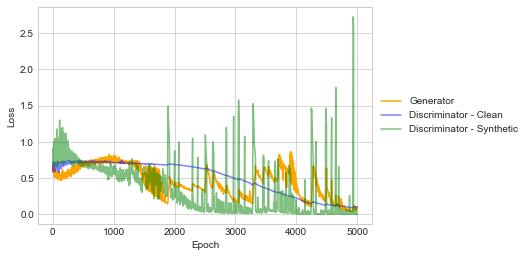

In [6]:
    gan.plot()
    from keras.utils import plot_model
    plot_model(gan.G, to_file='gen.png')
    plot_model(gan.D, to_file='dis.png')